[!toc]

# Advanced Model 
Gradient boosting decision tree

In [104]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing

In [18]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [11]:
from feature_selection.feature_selection import feature_selection, feature_selection_for_detection
from splitter import splitter

In [9]:
pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

## Prediction

### Feature Selection

In [4]:
file_list = list(Path(pred_path).glob("*.csv"))
samples = [f.name.split('.')[0] for f in file_list]

In [5]:
file_list[0].parent

WindowsPath('../files/SeizurePrediction')

In [6]:
res = pd.DataFrame(data_x)
res["result"] = data_y
res

NameError: name 'data_x' is not defined

In [16]:
file_list = [f for f in Path(dect_path).glob("*atient*.csv") if "reduced" not in f.name]
for f in file_list:
    # data = pd.read_csv(f.resolve(), header=None)
    sample = f.name.split('.')[0]
    print('='*10,sample,'='*10)
    data_x,data_y = feature_selection_for_detection(f.resolve())
    res = pd.DataFrame(data_x)
    res["result"] = data_y
    res.to_csv(os.path.join(f.parent.resolve(), sample+"_reduced.csv"), index=False)

========== Patient_1 ==========
Number of Observation(raw): 1044
Number of features(raw): 1905
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_2 ==========
Number of Observation(raw): 3141
Number of features(raw): 449
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_3 ==========
Number of Observation(raw): 1041
Number of features(raw): 1541
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_4 ==========
Number of Observation(raw): 210
Number of features(raw): 2017
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_5 ==========
Number of Observation(raw): 2745
Number of features(raw): 1793
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_6 ==========
Number of Observation(raw): 2997
Number of features(raw): 841
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_7 ==========
Number of Observation(raw): 3

In [ ]:
file_list = list(Path(pred_path).glob("*.csv"))
for f in file_list:
    # data = pd.read_csv(f.resolve(), header=None)
    sample = f.name.split('.')[0]
    print('='*10,sample,'='*10)
    data_x,data_y = feature_selection(f.resolve())
    res = pd.DataFrame(data_x)
    res["result"] = data_y
    res.to_csv(os.path.join(f.parent.resolve(), sample+"_reduced.csv"), index=False)

### balance data

In [108]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)


### gbdt

In [124]:
def train_pred(X, y, plotflag=False, save=False):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(fig_s)
    scaler = preprocessing.StandardScaler().fit(X)
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        gradient_boosting = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
        y_pred = gradient_boosting.predict(X_test)
        
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
    
        viz = plot_roc_curve(gradient_boosting, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        y_pred = gradient_boosting.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)
        accuracy = (tp+tn)/(tp+fn+fp+tn)
        PPV = tp / (tp+fp)
        f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
        print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))
    
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "gbdt_rocaoc_{}.pdf".format(save)))
    plt.show()
    return aucs


fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9512     ,    0.3077     ,    0.9201     ,    0.2424     ,    0.2712     
  1  ,    0.9453     ,    0.1538     ,    0.9071     ,    0.1250     ,    0.1379     
  2  ,    0.9336     ,    0.4231     ,    0.9089     ,    0.2444     ,    0.3099     
  3  ,    0.9453     ,    0.2000     ,    0.9106     ,    0.1515     ,    0.1724     
  4  ,    0.9316     ,    0.2800     ,    0.9013     ,    0.1667     ,    0.2090     
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      2560
         1.0       0.19      0.27      0.22       128

    accuracy                           0.91      2688
   macro avg       0.58      0.61      0.59      2688
weighted avg       0.93      0.91      0.92      2688



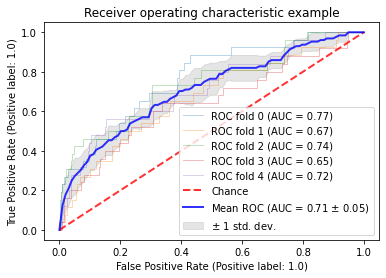

In [125]:
aucs = train_pred(data_x, data_y)

In [92]:
np.mean(aucs)

0.7917195207892882

In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, 1*(y_pred>0.5)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
accuracy = (tp+tn)/(tp+fn+fp+tn)
PPV = tp / (tp+fp)
[specificity,sensitivity,accuracy,PPV]

[0.9302325581395349, 0.5503875968992248, 0.7403100775193798, 0.8875]

In [31]:
X_train, X_test, y_train, y_test = splitter(data_x, data_y, split_ratio=0.2, scaler=True)

In [32]:
len(data_y)

2688

In [33]:
sss = StratifiedShuffleSplit(train_size=0.8, n_splits=5) 
for train_index, test_index in sss.split(data_x, data_y):
    print(sum(data_y[train_index]), len(train_index))

102.0 2150
102.0 2150
102.0 2150
102.0 2150
102.0 2150


## main

In [48]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    break

In [56]:
set(data_y)

{0.0, 1.0}

In [65]:

print(classification_report(y_test, 1*(y_pred>0.5)))

              precision    recall  f1-score   support

         0.0       0.67      0.93      0.78       516
         1.0       0.89      0.55      0.68       516

    accuracy                           0.74      1032
   macro avg       0.78      0.74      0.73      1032
weighted avg       0.78      0.74      0.73      1032



In [99]:
print("GB_Score = %.5f"%0.2555555555555)

GB_Score = 0.26
